# Quant Research/Trading Project on Roche

In this project I will be conducting research, deriving insights, and explaining my findings in regards to my position on Roche.

Economic data was retrieved from publicly available APIs. Financial statements were retrieved from the companys website. 


## Background

Roche is a Swiss multinational healthcare company that operates worldwide under two divisions: Pharmaceuticals and Diagnostics.

I will be looking into the stock, the companys financials, and other macro/microeconomic factors that might influence the stock price. I will also create data visualizations, and use statistics and math to back up my interpretations.

In [148]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
import wbdata as wb
import pandas_datareader as pdr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [124]:
roche_prices = yf.download('RHHBY', period='max')
roche_prices.reset_index(inplace=True)
roche_prices['Year'] = roche_prices['Date'].dt.year
roche_prices['Month'] = roche_prices['Date'].dt.month
roche_prices = roche_prices[roche_prices['Year'] > 2003]
roche_prices['Volume'] = roche_prices['Volume'] / 100000
roche_prices.head()


/home/mazin/.local/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/tmp/ipykernel_78697/1196285770.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roche_prices['Volume'] = roche_prices['Volume'] / 100000


,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month
93,2004-01-02,12.58125,12.65625,12.54375,12.58125,7.041757,3.744,2004,1
94,2004-01-05,12.70000,12.71875,12.56250,12.70000,7.108222,3.272,2004,1
95,2004-01-06,12.67500,12.71250,12.53125,12.67500,7.094227,3.672,2004,1
96,2004-01-07,12.45000,12.53125,12.39375,12.45000,6.968297,2.096,2004,1
97,2004-01-08,12.43750,12.59375,12.35000,12.43750,6.961299,2.768,2004,1


## Exploratory Data Analysis

Objectives:
* Derive insights about Roche's stock.
* Find relationships between Roche and microeconomic/macroeconomic factors.

For this part, I'll visualize various factors and their potential effects on Roche's Stock Price. The importance of each indicator will be quantitatively analyzed in the feature engineering section. I'll test feature importance, and vary the parameters by including/excluding certain features. At first, I'll include a wide pool of features that intuitively make sense to affect stock price.

Let's take a look at the stock opening price over time, along with volume.

           Date       Open       High        Low      Close  Adj Close  \
93   2004-01-02  12.581250  12.656250  12.543750  12.581250   7.041757   
94   2004-01-05  12.700000  12.718750  12.562500  12.700000   7.108221   
95   2004-01-06  12.675000  12.712500  12.531250  12.675000   7.094230   
96   2004-01-07  12.450000  12.531250  12.393750  12.450000   6.968295   
97   2004-01-08  12.437500  12.593750  12.350000  12.437500   6.961299   
...         ...        ...        ...        ...        ...        ...   
5154 2024-02-12  32.299999  32.630001  32.290001  32.599998  32.599998   
5155 2024-02-13  32.270000  32.360001  32.099998  32.130001  32.130001   
5156 2024-02-14  32.040001  32.090000  31.910000  32.020000  32.020000   
5157 2024-02-15  32.200001  32.400002  32.040001  32.099998  32.099998   
5158 2024-02-16  32.200001  32.369999  32.110001  32.279999  32.279999   

      Volume  Year  Month  
93     3.744  2004      1  
94     3.272  2004      1  
95     3.672  2004      1  

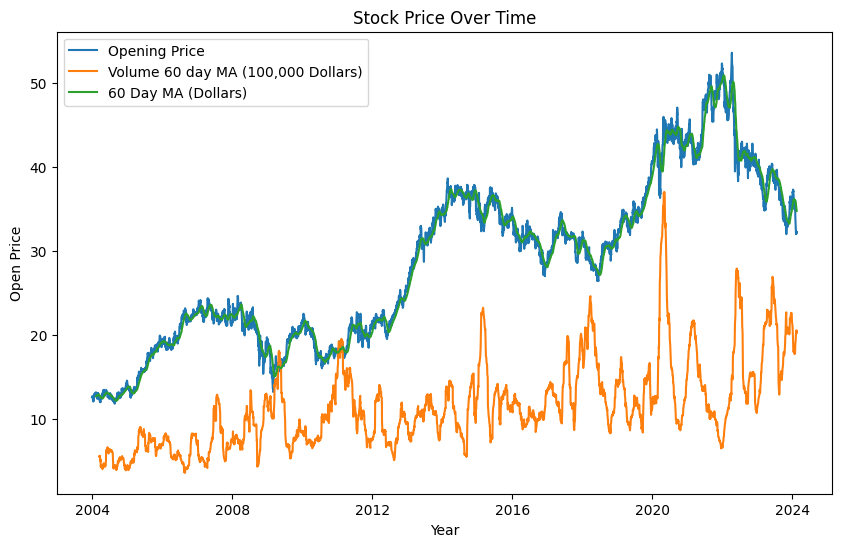

In [3]:
observation_column = "Open"

plt.figure(figsize=(10, 6))
plt.plot(roche_prices['Date'], roche_prices[observation_column], label='Opening Price')
plt.plot(roche_prices['Date'], roche_prices['Volume'].rolling(window=50).mean(), label='Volume 60 day MA (100,000 Dollars)')
plt.plot(roche_prices['Date'], roche_prices[observation_column].rolling(window=30).mean(), label='60 Day MA (Dollars)')
plt.title("Stock Price Over Time")
plt.xlabel('Year')
plt.ylabel('Open Price')
plt.legend()

print(roche_prices)

Stock Volume could be a great indicator of stock price. We could predict that when there are large volumes of shares sold/bought, that the stock is going to move - this agrees with supply and demand. All the available data that is measured as frequently as stock price is in the dataframe download from yahoo finance. In the meantime, lets examine some factors that are much less frequently measured.

General Observations from Roche's Financial Statements: Most of Roche's revenue comes from the United States. US Healthcare spend could be a good factor to look at. I also see that most of their revenue comes from their oncology department within pharmaceuticals. They make the most money on cancer solutions. I could look at cancer patient data as well as their Research and Development expense. A glaring observation is that Roche's stock had the longest steady increase as well as peaked in 2021-2022. This is when Covid happened, and I'm pretty sure Roche benefitted tremendously from it. However, analyses like that are usually reserved for a fundamental perspective, unless I could find a way to quantify it. For future work, I would try to look for ways to do that.

For economic factors, I'll examine some focused in Switzerland such as GDP, unemployment rate, inflation rate, interest rate, and currency exchange rate with the US Dollar. I'll also examine some factors from the companies financial statements, which I found online in excel. All of the information I need should be publicly accessible. 

It's worth noting that my first reservation with this data is that it's only collected annually. The amount of data available then will be really scarce, and in turn makes me wary of its usefulness as well as its accuracy. Perhaps a US based company would have their financial data released quarterly, and would be more easily accessible online. Nevertheless, these observations are collected via publicly accessible APIs.

In [4]:
# Indicator codes
gdp_indicator = {'NY.GDP.MKTP.CD': 'GDP'}
unemployment_indicator = {'SL.UEM.TOTL.ZS': 'UnemploymentRate'}
inflation_indicator = {'FP.CPI.TOTL.ZG': 'InflationRate'}
interest_indicator = {'FR.INR.RINR': 'InterestRate'}
country_us = {'USA': 'United States'}
country = {'CH': 'Switzerland'}

end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=365*21) 

interval = (start_date, end_date)

# swiss gross domestic product data
swiss_gdp = wb.get_dataframe(gdp_indicator, country, interval).iloc[::-1]
swiss_gdp.index = swiss_gdp.index.astype(int)
# print(swiss_gdp)

# swiss unemployment rates data
swiss_unemployment = wb.get_dataframe(unemployment_indicator, country, interval).iloc[::-1]
swiss_unemployment.index = swiss_unemployment.index.astype(int)
# print(swiss_unemployment)

# swiss inflation data
swiss_inflation = wb.get_dataframe(inflation_indicator, country, interval).iloc[::-1]
swiss_inflation.index = swiss_inflation.index.astype(int)
# print(swiss_inflation)

# swiss interest rates data
swiss_interest = wb.get_dataframe(interest_indicator, country, interval).iloc[::-1].dropna()
swiss_interest.index = swiss_interest.index.astype(int)
# print(swiss_interest)

# condense roche stock data to yearly
yearly_stock_prices = roche_prices.groupby(roche_prices['Date'].dt.year).last()[['Open']]
# yearly_stock_prices = roche_prices[roche_prices['Month'] == 3].groupby('Year').first()[['Open']]
yearly_stock_prices.index = yearly_stock_prices.index.astype(int)
# print(yearly_stock_prices)

# swiss exchange rates data
swiss_exchange = pdr.DataReader('DEXSZUS', 'fred', start=start_date, end=end_date)
swiss_exchange.rename(columns={'DEXSZUS': 'ExchangeRate'}, inplace=True)
swiss_exchange = swiss_exchange.groupby(swiss_exchange.index.year).last()
swiss_exchange['ExchangeRate'] = 1 / swiss_exchange['ExchangeRate']
swiss_exchange.index = swiss_exchange.index.astype(int)
# print(swiss_exchange)

# read and clean US healthcare spend data
us_healthcare_file = 'NHE22_Summary.csv'
us_healthcare = pd.read_csv(us_healthcare_file)
us_healthcare = us_healthcare.iloc[:3]
columns = [1959 + i for i in range(len(us_healthcare.columns))]
columns[0] = 'Year'
us_healthcare.columns = columns
drop = [i for i in range(1960, 2008)]
us_healthcare.drop(drop, axis=1, inplace=True)
us_healthcare = us_healthcare.T
us_healthcare.drop([0,2], axis=1, inplace=True)
us_healthcare.drop('Year', inplace=True)
columns = ["Healthcare Spend"]
us_healthcare.columns = columns
us_healthcare['Healthcare Spend'] = us_healthcare['Healthcare Spend'].astype('float') / 1000
print(type(us_healthcare['Healthcare Spend'][2008]))
print(us_healthcare)


# read and clean income data
income_file = 'Roche_Income_Segment.xlsx'
roche_income = pd.read_excel(income_file)
columns = [col for col in roche_income.columns]
for i in range(1, len(columns)):
    columns[i] = i-1
columns[0] = 'Segment'
roche_income.columns = columns
roche_income.drop([0,1,2,3,4], inplace=True)
roche_income.drop(0, axis=1, inplace=True)
columns = [col for col in roche_income.columns]
for i in range(1, len(roche_income.columns)):
    columns[i] = 2008+i
roche_income.columns = columns
roche_income = roche_income.drop(roche_income.columns[16:], axis=1)
rows = ['External Revenue', 'Operating Margin (%)']
roche_income['Segment'] = roche_income['Segment'].str.strip()
roche_income = roche_income[roche_income['Segment'].isin(rows)]
roche_income = roche_income.T
columns = ['Revenue', 'Operating Margin']
roche_income.columns = columns
roche_income.drop('Segment', inplace=True)
roche_income['Revenue'] = roche_income['Revenue'] / 1000
roche_income['Operating Margin'] = roche_income['Operating Margin'].str.strip()
roche_income['Operating Margin'] = roche_income['Operating Margin'].str.rstrip('%').astype('float')
# print(roche_income)

<class 'numpy.float64'>
      Healthcare Spend
2008            2.4024
2009            2.4927
2010            2.5896
2011            2.6765
2012            2.7833
2013            2.8557
2014            3.0017
2015            3.1638
2016            3.3053
2017            3.4437
2018            3.6012
2019            3.7564
2020            4.1563
2021            4.2891
2022            4.4646


I collected annual observations for various features. All observations are recorded in the range 2009-2022. Before 2009, a lot of data is missing. Here I melt the data together, and plot it.

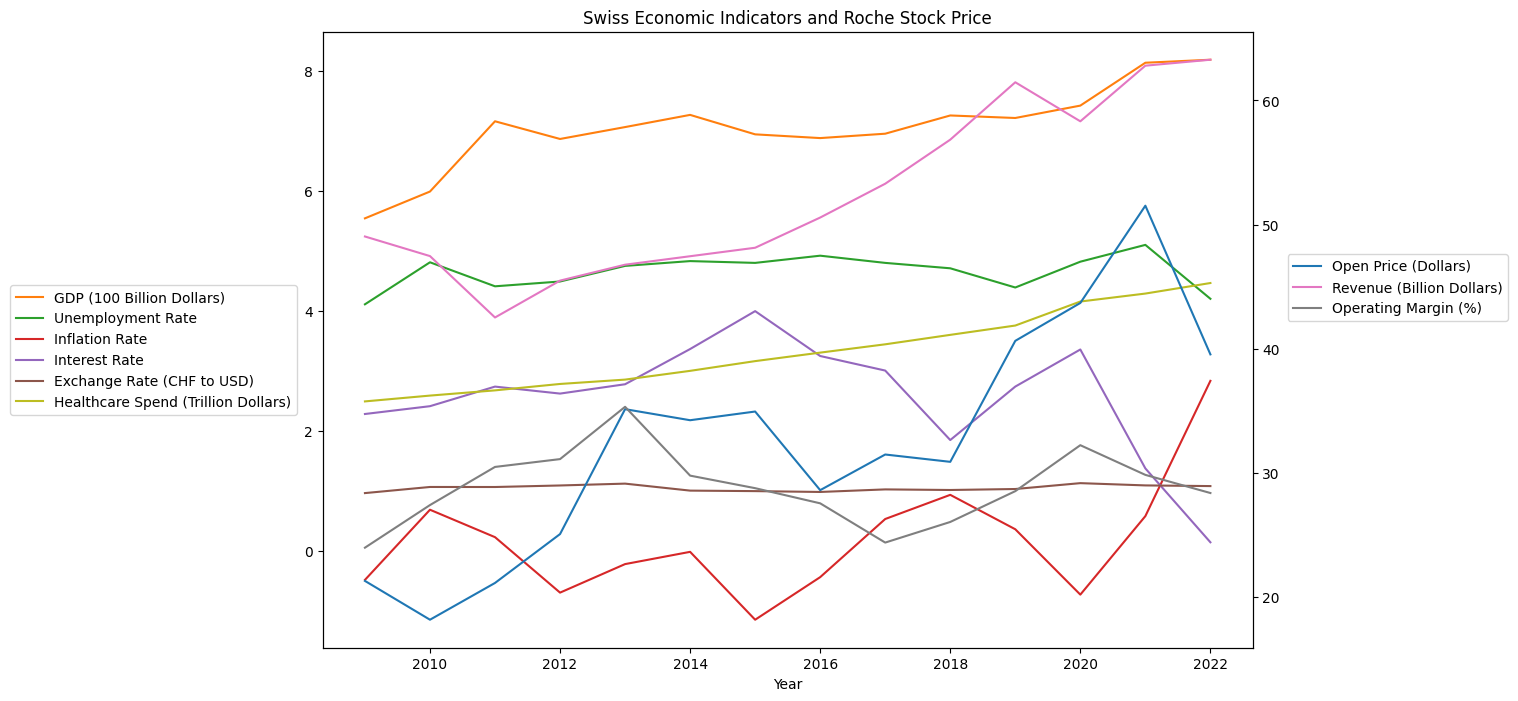

In [12]:
merged = pd.concat([yearly_stock_prices, swiss_gdp, swiss_unemployment, swiss_inflation, swiss_interest, swiss_exchange, roche_income, us_healthcare], axis=1).dropna()
merged['GDP'] = merged['GDP'] / 100000000000 
ax = merged.plot(title='Swiss Economic Indicators and Roche Stock Price', xlabel="Year", secondary_y=['Open', 'Revenue', 'Operating Margin'], figsize=(12, 8))
legend_labels = ['GDP (100 Billion Dollars)', 'Unemployment Rate', 'Inflation Rate', 'Interest Rate', 'Exchange Rate (CHF to USD)', 'Healthcare Spend (Trillion Dollars)']
ax.legend(legend_labels, bbox_to_anchor=(-0.02, 0.6))
ax.right_ax.legend(['Open Price (Dollars)', 'Revenue (Billion Dollars)', 'Operating Margin (%)'], bbox_to_anchor=(1.03, 0.65))
plt.show()
# print(merged)

Looking at this data, it looks like GDP and revenue loosely follow the stock prices motions. I expect them to have a high correlation. For the others, they seem more random. These are ambiguous. Let's calculate each factor's correlation with the stock price quantitatively.

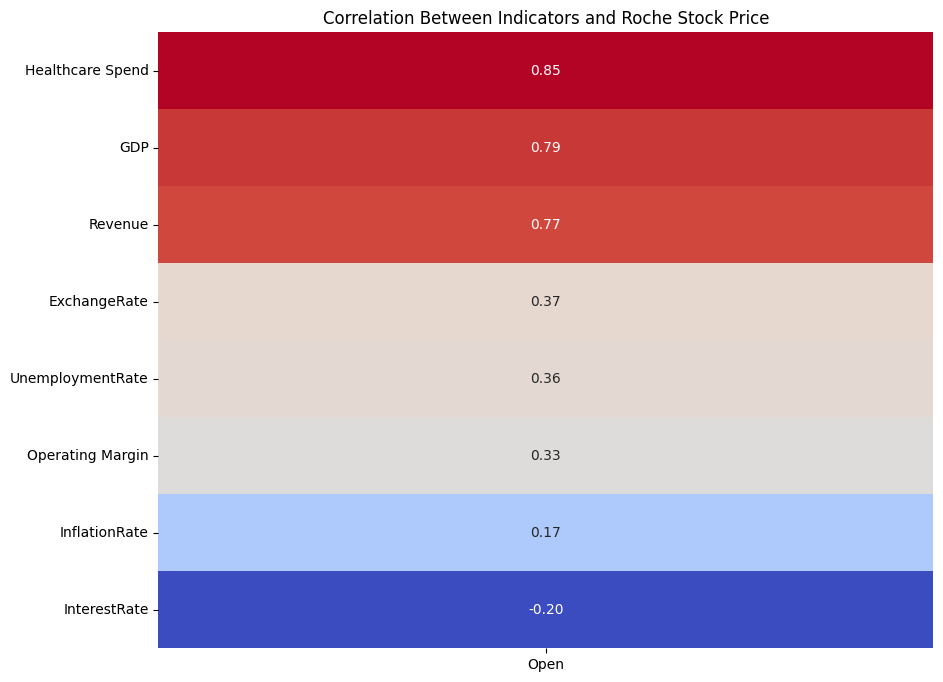

In [57]:
corr_matrix = merged.corr()
corr_matrix = corr_matrix['Open'].to_frame()

corr_matrix = corr_matrix.iloc[1:]
# sort by value
corr_matrix = corr_matrix.sort_values(by='Open', ascending=False)

# print(corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=False)
plt.title(f'Correlation Between Indicators and Roche Stock Price')
plt.show()

Seems like Healthcare Spend, GDP, and Revenue are most positively correlated, and pretty highly. If there were more observations, I would do statistical analysis on each factor to test whether there was a correlation or not, and look at the p-value to make my conclusion. I doubt those statistics would be meaningful for less than 20 observations. Instead, in the feature engineering section, I'll fit a model to the data and use the importance metric of each feature to make my decisions.

## Feature Engineering
Objectives:
* Create relevant features for my models.
* Explain my choice of why these features are important.

I want to model stock price using the features collected, and I want to examine their importance. To do this, I want to use a powerful model that Python allows me to easily plug and play, and accounts for non-linear relationships (otherwise Ordinary Least Squares would suffice). There are a variety of machine learning libraries and models to do this - I will use RandomForestRegressor from scikit-learn. This will be an iteration process - I'll fit the model to the data, and then I'll take a look at the feature importance. If there are insignificant features, I'll remove them and train again.

At this point it's also important to note that we are at risk of overfitting, which means the model might perform better on this dataset (which it trained on) versus another dataset. Usually, to combat this, we could try training the model on 50% of the dataset, and testing it against the other 50%. However, since the number of observations are so low, it will definitely not be enough for any meaninful fitting to happen if we cut any of the data. Usually this is done when there are a plethora of observations. This furthers my concern of overfitting, which is just going to be a concern when dealing with annual observations.

Mean Squared Error: 5.173447356740817


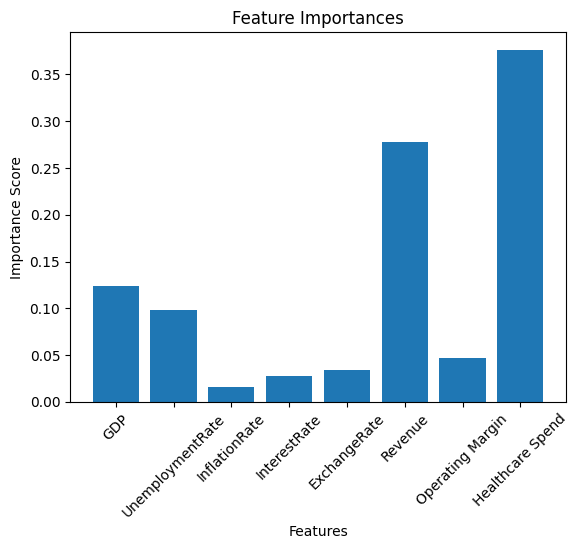

In [58]:
Y = merged['Open']
X = merged.drop('Open', axis=1)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, Y)

predictions = model.predict(X)

mse = mean_squared_error(Y, predictions)
print(f'Mean Squared Error: {mse}')


importances = model.feature_importances_

plt.bar(X.columns, importances)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45)
plt.show()


Looking at the feature importances, it looks like some of them are statistically insignificant. Since the correlation coefficient and feature importance of the features agree, I'll remove the low ones from the model, and see if the error is reduced. The mean squared error is 5.17, which means on average the model is off by about $2.3.

Mean Squared Error: 4.400301313157948


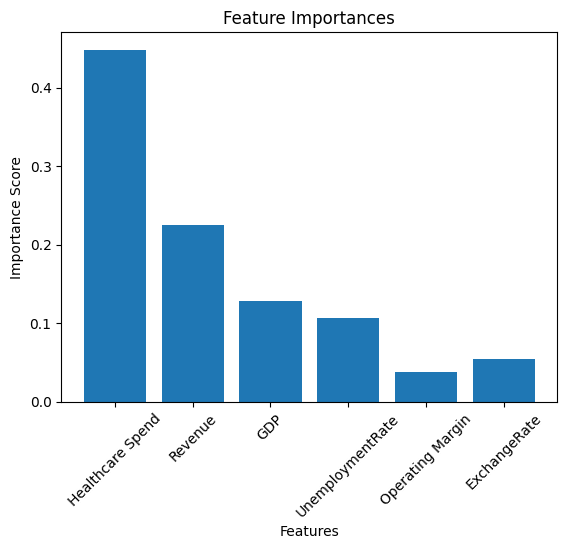

In [59]:
Y = merged['Open']
X = merged[['Healthcare Spend','Revenue','GDP','UnemploymentRate', 'Operating Margin','ExchangeRate', ]]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, Y)

predictions = model.predict(X)

mse = mean_squared_error(Y, predictions)
print(f'Mean Squared Error: {mse}')


importances = model.feature_importances_

plt.bar(X.columns, importances)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45)
plt.show()


Taking away the two least important features, we arrive at a 4.4 mean squared error, which means on average the model is off by $2.1.

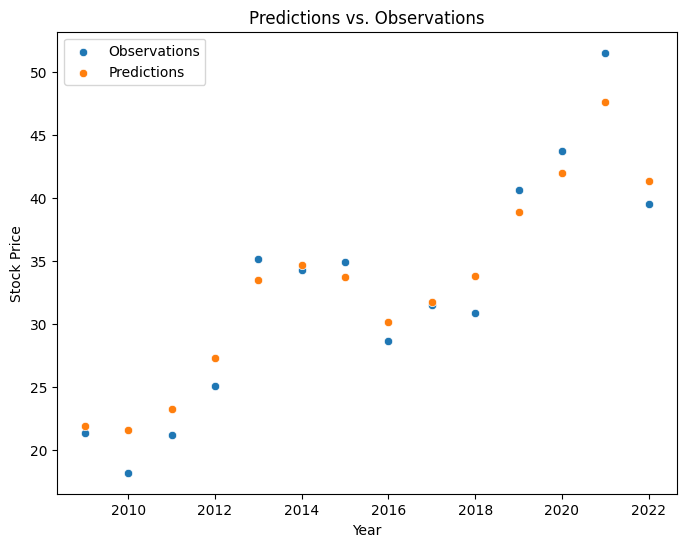

In [60]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=merged.index, y=Y, label='Observations')
sns.scatterplot(x=merged.index, y=predictions, label='Predictions')
plt.title('Predictions vs. Observations')
plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

For predicting a stock price solely based on these factors annually, this is pretty good. If we were confident in this model predicting within $2, a lot could be done given an entire year of downtime. However, for predictive modeling, given how much change occurs in a year and also considering the information isnt available for 2023, and also isnt available until the end of 2024 for this year, I would guess this model will need to be tested given more data.

What I want to try now, aside from factors that can only be measured at a yearly rate, or at best quarterly, is to use the previous 2 days financial data to predict the next. To do this, I will create a lagging indicator of each original observation by 1 and 2 days. I'm interested to see how this will perform. I will repeat most of the steps I ddid above, but I will quickly get to predictive modeling.

In [125]:
roche_prices = roche_prices.drop(['Date', 'Year', 'Month'], axis=1)
for i,col in enumerate(roche_prices.columns):
    roche_prices[col+"_1"] = roche_prices[col].shift(1)
    roche_prices[col+'_2'] = roche_prices[col].shift(2)
    if col != 'Close':
        roche_prices.drop(col, axis=1, inplace=True)
roche_lagged = roche_prices.dropna().iloc[:-5]
predict_set = roche_prices.dropna().iloc[-5:]

print(roche_lagged.head())
print(roche_prices.head())


      Close   Open_1    Open_2    High_1    High_2     Low_1     Low_2  \
95  12.6750  12.7000  12.58125  12.71875  12.65625  12.56250  12.54375   
96  12.4500  12.6750  12.70000  12.71250  12.71875  12.53125  12.56250   
97  12.4375  12.4500  12.67500  12.53125  12.71250  12.39375  12.53125   
98  12.3500  12.4375  12.45000  12.59375  12.53125  12.35000  12.39375   
99  12.2125  12.3500  12.43750  12.40625  12.59375  12.25000  12.35000   

    Close_1   Close_2  Adj Close_1  Adj Close_2  Volume_1  Volume_2  
95  12.7000  12.58125     7.108222     7.041757     3.272     3.744  
96  12.6750  12.70000     7.094227     7.108222     3.672     3.272  
97  12.4500  12.67500     6.968297     7.094227     2.096     3.672  
98  12.4375  12.45000     6.961299     6.968297     2.768     2.096  
99  12.3500  12.43750     6.912326     6.961299     4.224     2.768  
       Close    Open_1    Open_2    High_1    High_2     Low_1     Low_2  \
93  12.58125       NaN       NaN       NaN       NaN       

                Close
Close        1.000000
Open_1       0.998893
Open_2       0.998139
High_1       0.998950
High_2       0.998212
Low_1        0.998939
Low_2        0.998188
Close_1      0.999088
Close_2      0.998338
Adj Close_1  0.979839
Adj Close_2  0.979248
Volume_1     0.223244
Volume_2     0.223230
         Open_1     Open_2     High_1     High_2      Low_1      Low_2  \
95    12.700000  12.581250  12.718750  12.656250  12.562500  12.543750   
96    12.675000  12.700000  12.712500  12.718750  12.531250  12.562500   
97    12.450000  12.675000  12.531250  12.712500  12.393750  12.531250   
98    12.437500  12.450000  12.593750  12.531250  12.350000  12.393750   
99    12.350000  12.437500  12.406250  12.593750  12.250000  12.350000   
...         ...        ...        ...        ...        ...        ...   
5149  34.000000  34.310001  34.020000  34.380001  33.700001  33.869999   
5150  33.189999  34.000000  33.349998  34.020000  32.849998  33.700001   
5151  32.700001  33.189999

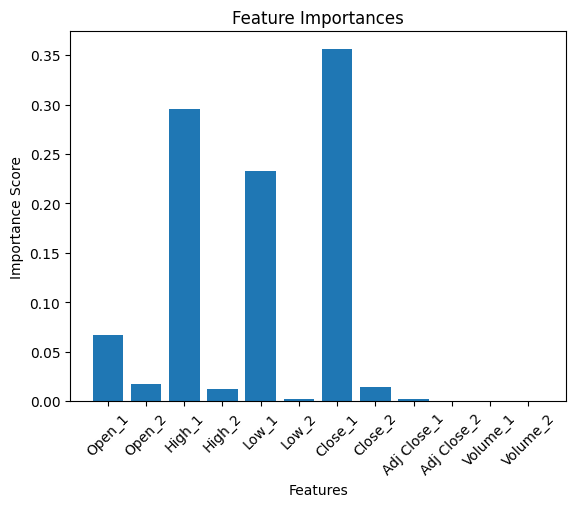

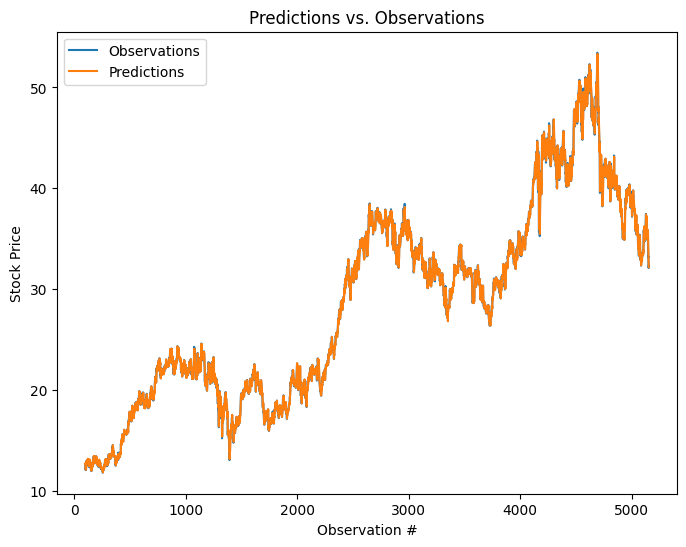

Mean Squared Error: 0.17235180978393433


In [165]:
corr = roche_lagged.corr()
corr = corr['Close'].to_frame()
print(corr)

X = roche_lagged.drop('Close', axis=1)
Y = roche_lagged['Close']
print(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train, Y_train)

predictions = model.predict(X_test)

mse = mean_squared_error(Y_test, predictions)
print(f'Mean Squared Error: {mse}')

importances = model.feature_importances_

plt.bar(X.columns, importances)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45)
plt.show()


X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
# print(model.summary())

predictions_ols = model.predict(X)

plt.figure(figsize=(8, 6))
sns.lineplot(x=roche_lagged.index, y=Y, label='Observations')
sns.lineplot(x=roche_lagged.index, y=predictions_ols, label='Predictions')
plt.title('Predictions vs. Observations')
plt.xlabel('Observation #')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

mse = mean_squared_error(Y, predictions_ols)
print(f'Mean Squared Error: {mse}')




It looks like the Close from the day before, and the High and Low from the day before have a huge importance on predicting the next day's Close. The mean square error is also extremely low. Let's see how this predicts some stock prices. I've saved the last 5 days of data as untrained data for the model to predict on. Since the linear regresions MSE is lower, we'll use that to predict.

## Predictive Modeling
Objectives:
* Create a model to forecast prices.
* Evaluate my models performance.
* Discuss pros/cons of the models.


0.07093238270160038


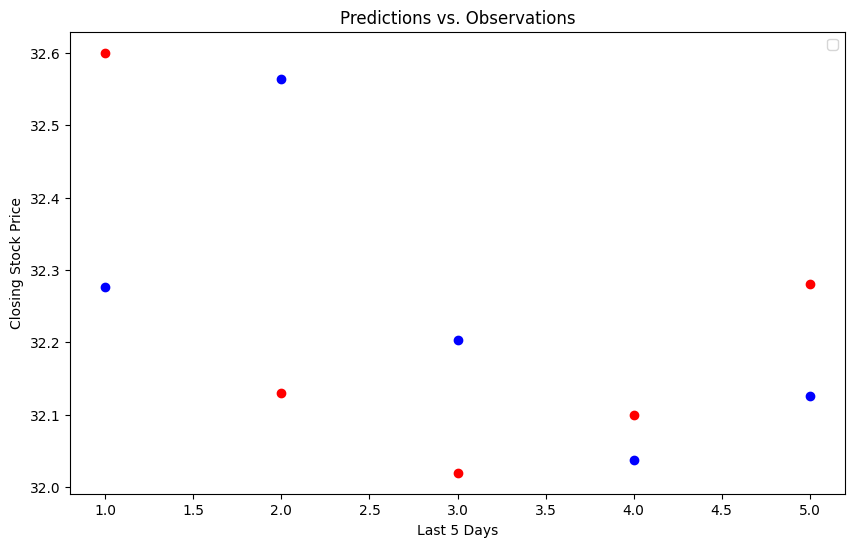

In [164]:
predict_s = predict_set.drop('Close', axis=1)
predict_s = sm.add_constant(predict_s)
# print(predict_s)
predictions = model.predict(predict_s)
# print(predictions)
# print(predict_set['Close'])

actual_observations = predict_set['Close']
mse = mean_squared_error(predict_set['Close'], predictions)
print(mse)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(range(1,6), predictions, color='blue')
plt.scatter(range(1,6), actual_observations, color='red')
plt.xlabel('Last 5 Days')
plt.ylabel('Closing Stock Price')
plt.title('Predictions vs. Observations')
plt.legend()
plt.show()



## Recommendation

The analysis of available data suggests a strong correlation between select features and stock price. Notably, key indicators like revenue, US healthcare spending, and Swiss GDP demonstrate a positive relationship with stock performance. This implies that as these macroeconomic factors improve, the stock tends to exhibit positive movement. Additionally, the observation that the stock performs well during periods of increased demand for healthcare, such as COVID, suggests that the stock may improve during sickness seasons - such as flu season. 

My recommendation would be to NOT open a position on Roche for now. It seems like the stock is on the come-down of a lucrative COVID season, which heavily boosts their pharmaceutical revenue. This becomes a potential risk - it's hard to say how much of the stock's current valuation is still benefitting. Otherwise, the companys revenue is steadily increasing over time, as well as Swiss GDP, but a good idea would be to keep an eye on healthcare spend. It would also be interesting if in the near future there are advances in cancer research. 

Presidential elections are coming up and could pose an interesting effect on healthcare spend depending depending on the President-Elect's policies. 
The demand for Roche's products will not diminish anytime soon as they're pouring billions of dollar into research and development, and have a few proprietary products they patented. Their cancer research is cutting edge, and they have a huge market share. They will most likely continue dominating competition wise. 

In conclusion, my recommendation would be to hold off investing in Roche for a bit, as the healthcare industry was in a huge bubble because of COVID, and the market is still on the come down from that bubble bursting. It will be worth keeping an eye on the factors mentioned.





